In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import riskfolio as rp
from datetime import datetime
import matplotlib.pyplot as plt

In [36]:
#Import selected ticker for portfolio selection
tickers = ['XDW0.MI','XDWT.MI','XDWC.MI','XDWH.MI','NUCL.MI','INFR.MI','XDWM.MI','XAIX.MI','ENER.MI','SEME.MI']
tickers.sort()

start = "2019-01-01"
end = datetime.today().date()

#Download Time series and calculate features
P = yf.download(tickers, start=start, end=end)["Close"]
P.index = pd.to_datetime(P.index)
P.columns = tickers


P2 = P[['XDWH.MI','XDWT.MI','INFR.MI','XDWM.MI']]
P2.bfill
sample = pd.DataFrame(P2.columns)

Y = P2.pct_change().dropna() 
display(Y.head())
display(Y.tail())

dcorr = pd.DataFrame(np.corrcoef(Y))
corr = Y.corr()
display(corr)
# Creare portafoglio ipotizzando i 4 ETF selezionati prima, utilizzando il metodo minRisk e comparando
# le diverse misure di rischio prima (optare per il CVaR poi con estimation mean BS), mettere eventuali
# constraints se la minimizzazione del rischio non restituisce un pesi ottimali
# Create the portfolio


[*********************100%%**********************]  10 of 10 completed


,XDWH.MI,XDWT.MI,INFR.MI,XDWM.MI
Date,,,,
2019-01-03,-0.013236,-0.038799,-0.005434,0.000000
2019-01-04,0.020404,0.024748,0.018666,0.000000
2019-01-07,0.003333,0.006331,-0.001788,0.026161
2019-01-08,0.001845,0.006524,0.013432,0.000000
2019-01-09,0.009026,0.014352,-0.001325,0.009961


,XDWH.MI,XDWT.MI,INFR.MI,XDWM.MI
Date,,,,
2024-07-25,0.009178,-0.014351,0.003072,-0.007295
2024-07-26,0.000967,-0.001381,0.002893,0.008819
2024-07-29,0.001547,-0.000880,0.006617,0.002368
2024-07-30,0.000772,-0.012580,0.005731,0.000908
2024-07-31,0.006365,0.031979,0.006704,0.015429


c:\Users\cdecinti\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\cdecinti\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


,XDWH.MI,XDWT.MI,INFR.MI,XDWM.MI
XDWH.MI,1.000000,0.667058,0.724203,0.570324
XDWT.MI,0.667058,1.000000,0.543212,0.588719
INFR.MI,0.724203,0.543212,1.000000,0.658006
XDWM.MI,0.570324,0.588719,0.658006,1.000000


In [3]:
# Creo oggetto portafoglio
port = rp.Portfolio(returns=Y)
method_mu = "JS"
method_cov = "ledoit"

port.assets_stats(method_mu=method_mu, method_cov=method_cov, d = 0.94)
model = "Classic"
obj = "Sharpe"
rf = 0
l = 0

# Creo portafoglio con le misure di rischio da minimizzare diverse e confronto graficamente i pesi
rms = ['MV', 'MAD', 'MSV', 'FLPM', 'SLPM', 'CVaR',
        'WR', 'MDD', 'ADD', 'CDaR', 'UCI']

w_s = pd.DataFrame([])

for i in rms:
    w = port.optimization(model=model, rm=i, obj=obj, rf=rf, l=l, hist=True)
    w_s = pd.concat([w_s, w], axis=1)
    
w_s.columns = rms

w_s.style.format("{:.2%}").background_gradient(cmap='YlGn')

,MV,MAD,MSV,FLPM,SLPM,CVaR,WR,MDD,ADD,CDaR,UCI
XDWH.MI,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,54.19%,50.63%,63.04%
XDWT.MI,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%,32.04%,49.37%,35.32%
INFR.MI,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
XDWM.MI,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,13.77%,0.00%,1.64%


In [5]:
#Seleziono le metriche di rischio che voglio approfondire
rms2 = ["MV","ADD","CVaR", "CDaR"]

w_s2 = pd.DataFrame([])

for i in rms2:
    w2 = port.optimization(model=model, rm=i, obj=obj, rf=rf, l=l, hist=True)
    w_s2 = pd.concat([w_s2, w2], axis=1)
    
w_s2.columns = rms2
w_s2.style.format("{:.2%}").background_gradient(cmap='YlGn')


,MV,ADD,CVaR,CDaR
XDWH.MI,0.00%,54.19%,0.00%,50.63%
XDWT.MI,100.00%,32.04%,100.00%,49.37%
INFR.MI,0.00%,0.00%,0.00%,0.00%
XDWM.MI,0.00%,13.77%,0.00%,0.00%


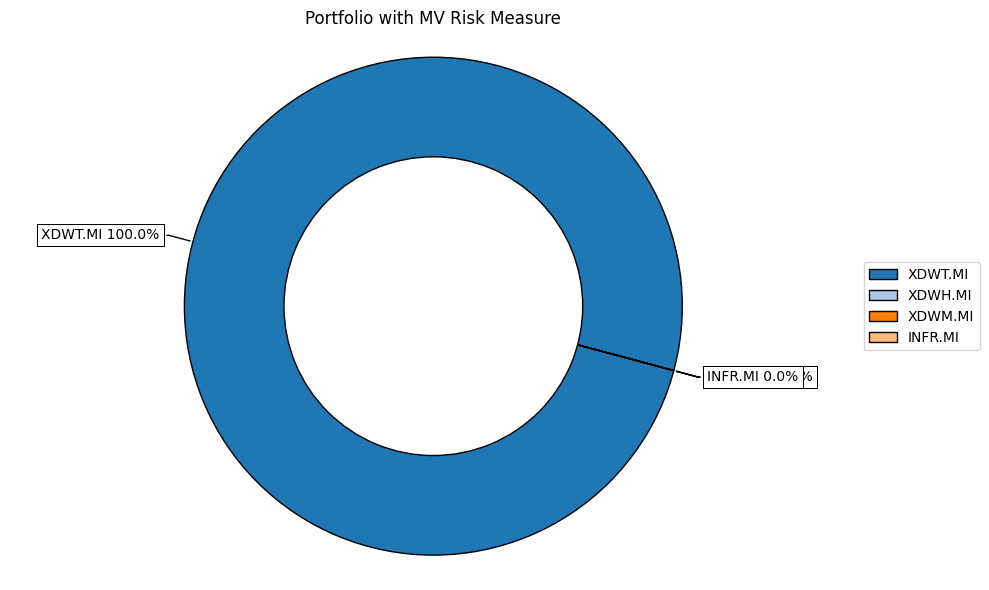

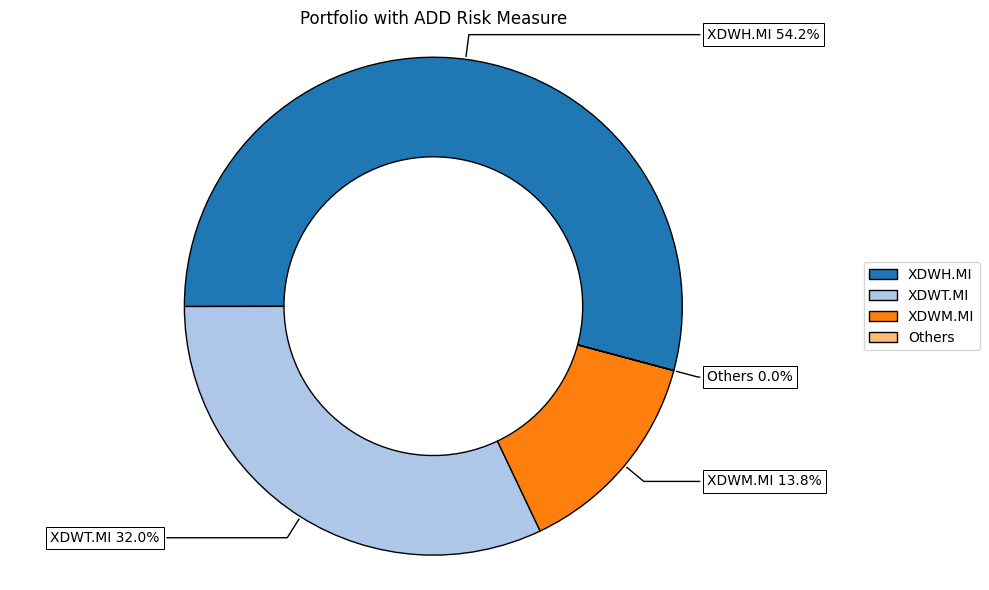

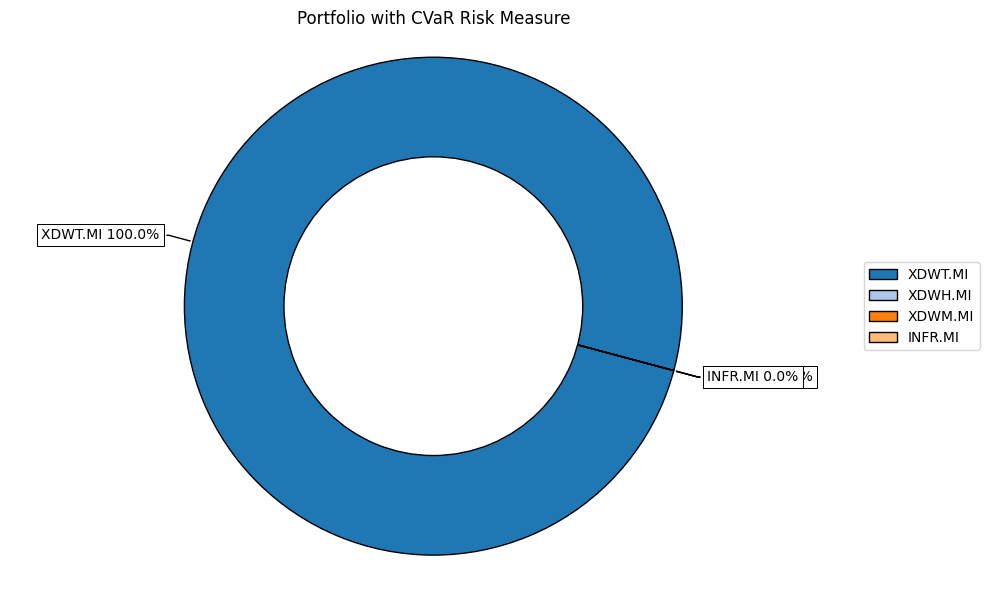

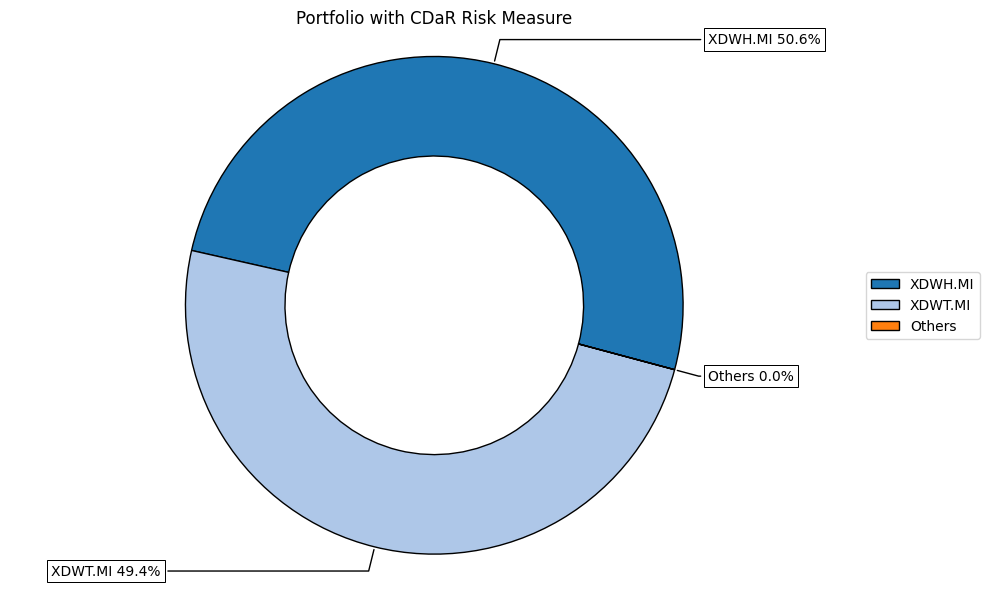

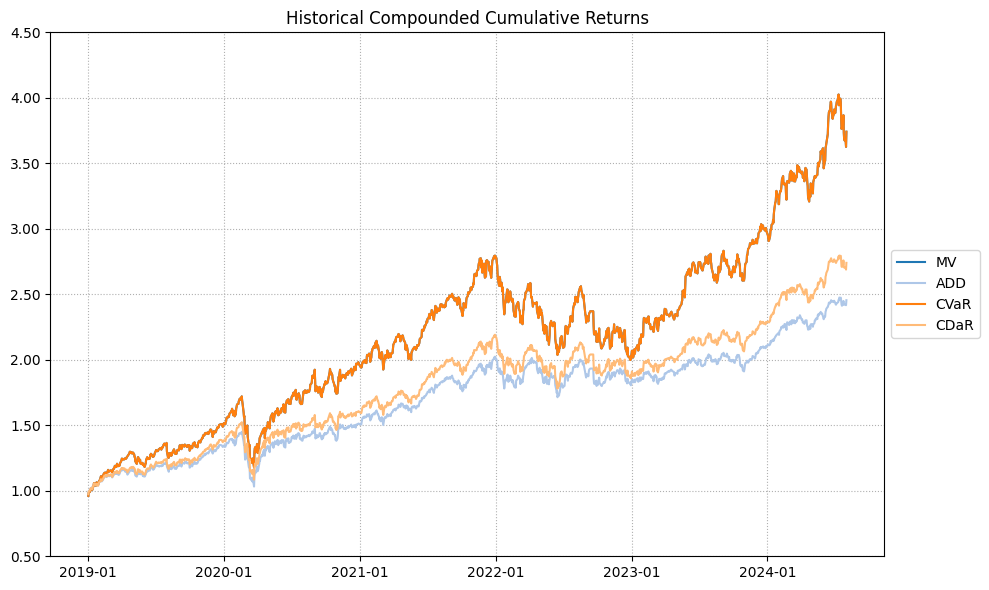

In [6]:
#Create singulare Pie chart

for i in w_s2.columns:
    ax = rp.plot_pie(w=w_s2[[i]], title=f'Portfolio with {i} Risk Measure', others=0.05, nrow=25, cmap = "tab20",
                     height=6, width=10, ax=None)
    plt.show()

# Plottare il grafico dei rendimenti cumulati
ax1 = rp.plot_series(returns=Y,
                    w = w_s2,
                    cmap="tab20",
                    height=6,
                    width=10,
                    ax=None)


In [7]:
# Inserisco i constraints
asset_classes = {'Assets': ['XDWH.MI','XDWT.MI','INFR.MI','XDWM.MI'], 
                 'Industry': ['Health Care','Information Technology',
                              'Infrastructure','Materials']}

asset_classes = pd.DataFrame(asset_classes)
asset_classes = asset_classes.sort_values(by=['Assets'])

constraints = {'Disabled': [False, False, False, False, False],
               'Type': ['All Assets', 'Classes', 'Classes', 'Classes',
                        'Classes'],
               'Set': ['', 'Industry', 'Industry', 'Industry', 'Industry'],
               'Position': ['', 'Health Care', 'Information Technology', 'Infrastructure',
                            'Materials'],
               'Sign': ['>=', '>', '>', '>', '>'],
               'Weight': [0.1, 0, 0, 0, 0],
               'Type Relative': ['', '', '', '', ''],
               'Relative Set': ['', '', '', '', ''],
               'Relative': ['', '', '', '', ''],
               'Factor': ['', '', '', '', '']}

constraints = pd.DataFrame(constraints)
display(constraints)
A, B = rp.assets_constraints(constraints, asset_classes)

port2 = rp.Portfolio(returns=Y)
port2.assets_stats(method_mu=method_mu, method_cov=method_cov, d = 0.94)
port2.ainequality = A
port2.binequality = B

w_s3 = pd.DataFrame([])

for i in rms2:
    w3 = port2.optimization(model=model, rm=i, obj=obj, rf=rf, l=l, hist=True)
    w_s3 = pd.concat([w_s3, w3], axis=1)

w_s3.columns = rms2
w_s3.style.format("{:.2%}").background_gradient(cmap='YlGn')


,Disabled,Type,Set,Position,Sign,Weight,Type Relative,Relative Set,Relative,Factor
0,False,All Assets,,,>=,0.1,,,,
1,False,Classes,Industry,Health Care,>,0.0,,,,
2,False,Classes,Industry,Information Technology,>,0.0,,,,
3,False,Classes,Industry,Infrastructure,>,0.0,,,,
4,False,Classes,Industry,Materials,>,0.0,,,,


,MV,ADD,CVaR,CDaR
XDWH.MI,10.00%,28.50%,10.00%,30.49%
XDWT.MI,70.00%,38.60%,70.00%,49.51%
INFR.MI,10.00%,10.00%,10.00%,10.00%
XDWM.MI,10.00%,22.90%,10.00%,10.00%


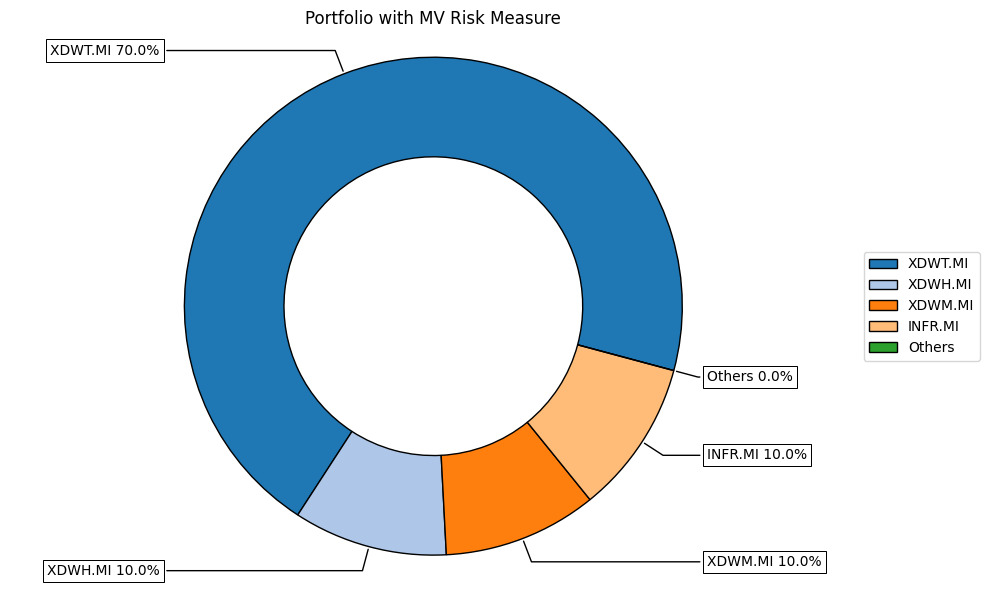

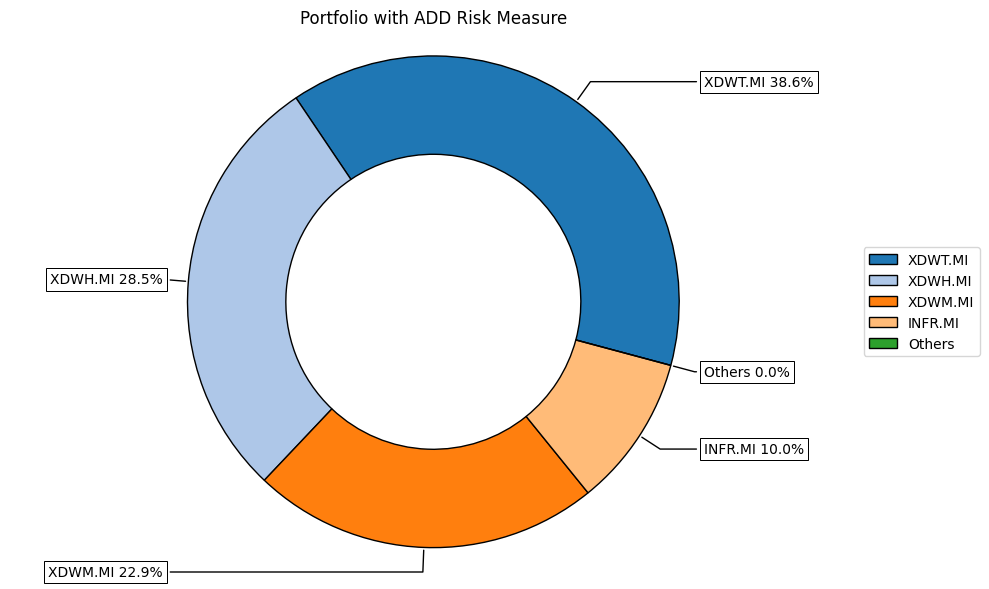

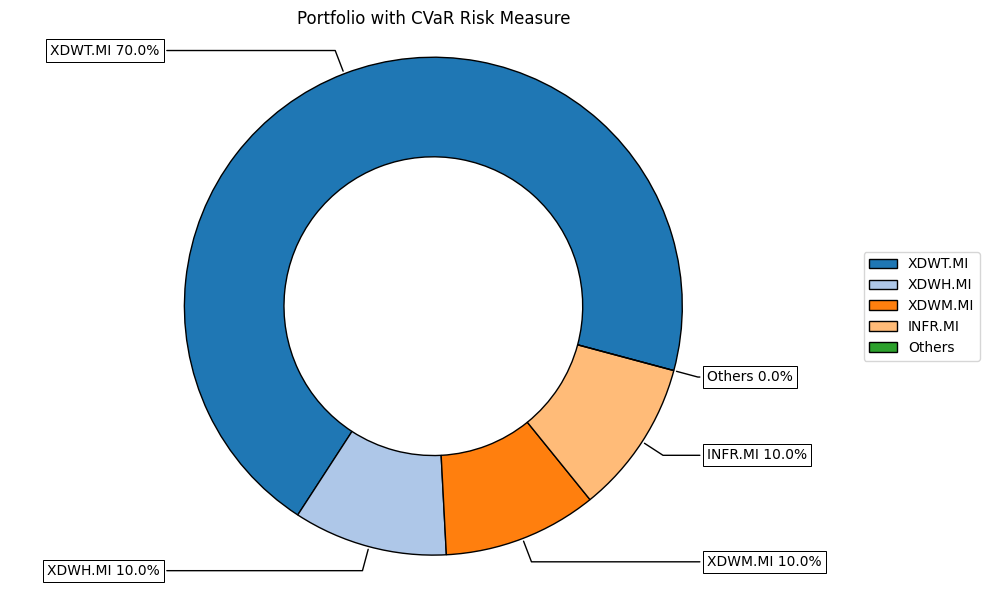

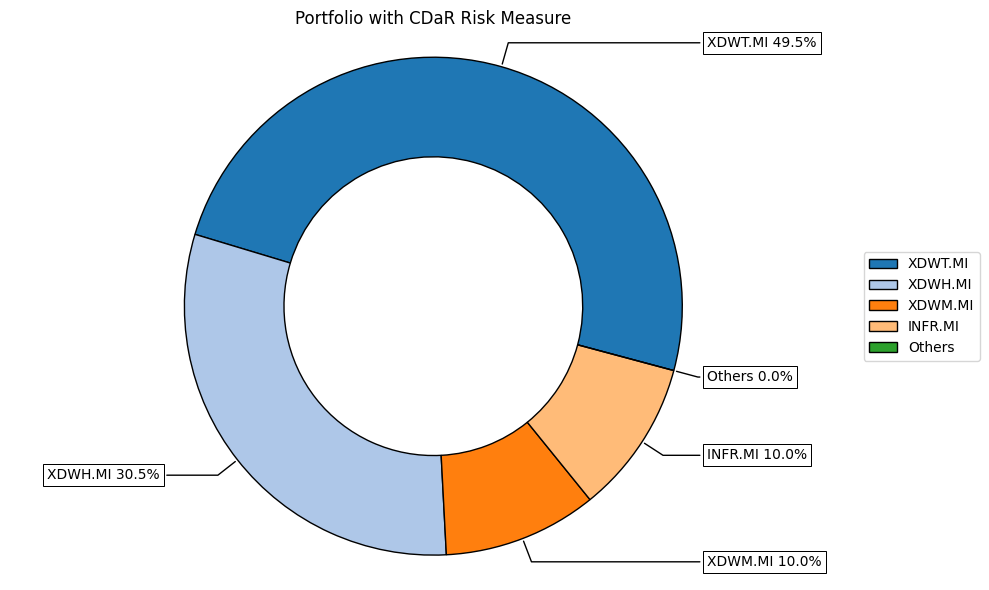

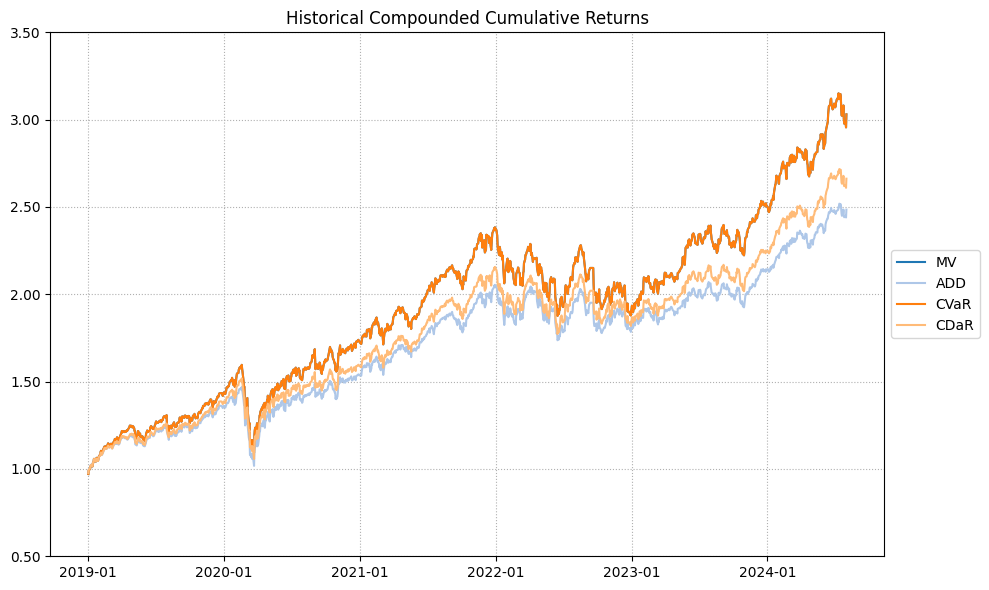

In [8]:
#Create singulare Pie chart

for i in w_s3.columns:
    ax = rp.plot_pie(w=w_s3[[i]], title=f'Portfolio with {i} Risk Measure', others=0.05, nrow=25, cmap = "tab20",
                     height=6, width=10, ax=None)
    plt.show()

# Plottare il grafico dei rendimenti cumulati
ax1 = rp.plot_series(returns=Y,
                    w = w_s3,
                    cmap="tab20",
                    height=6,
                    width=10,
                    ax=None)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
XDWH.MI,0.47581,0.598483,0.565660,0.528916,0.497286,0.468934,0.442971,0.41124,0.379441,0.349345,0.320648,0.29312,0.266588,0.240915,0.215994,0.191733,0.16806,0.144915,0.122243,0.1
XDWT.MI,0.10000,0.120971,0.179962,0.232278,0.277324,0.317684,0.354715,0.38876,0.420559,0.450654,0.479352,0.50688,0.533412,0.559085,0.584006,0.608267,0.63194,0.655085,0.677757,0.7
INFR.MI,0.32419,0.113062,0.100000,0.100000,0.100000,0.100000,0.100000,0.10000,0.100000,0.100000,0.100000,0.10000,0.100000,0.100000,0.100000,0.100000,0.10000,0.100000,0.100000,0.1
XDWM.MI,0.10000,0.167485,0.154378,0.138806,0.125390,0.113382,0.102314,0.10000,0.100000,0.100000,0.100000,0.10000,0.100000,0.100000,0.100000,0.100000,0.10000,0.100000,0.100000,0.1


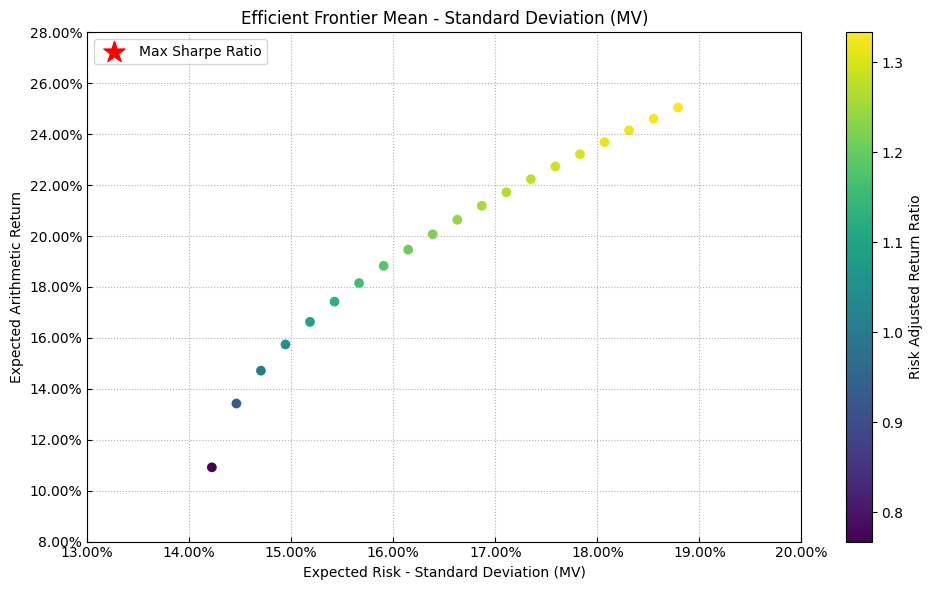

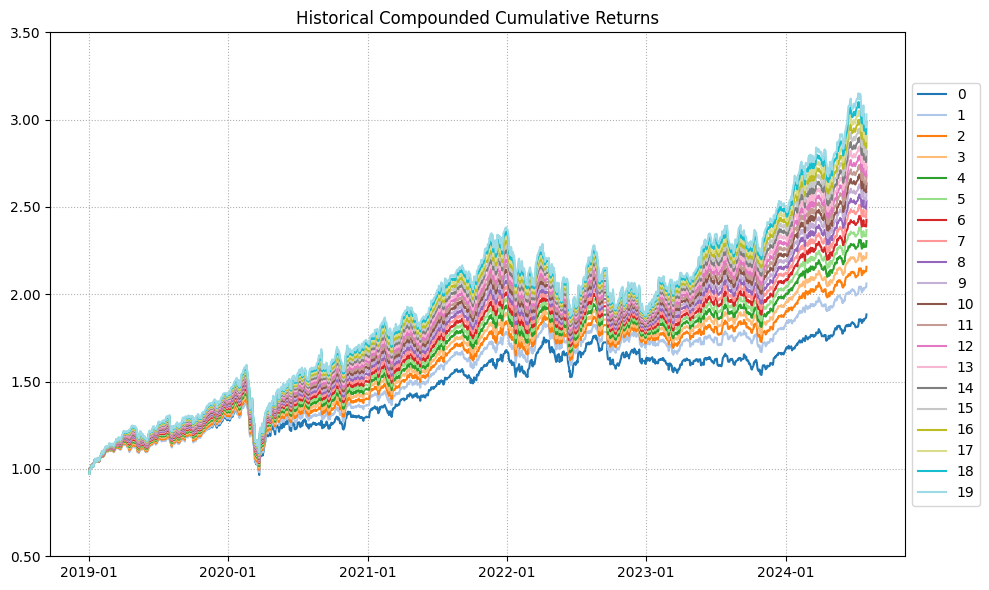

In [50]:
# Creare le frontiere efficienti per ogni metodologia di risk measure
#Mean - Variance
points = 20 # Number of points of the frontier

frontierMV = port2.efficient_frontier(model=model, rm="MV", points=points, rf=rf, hist=True)

display(frontierMV)

# Grafico
label = 'Max Sharpe Ratio' # Title of point

axMV = rp.plot_frontier(w_frontier=frontierMV, mu=port2.mu, cov=port2.cov, returns=Y, rm="MV",
                      rf=rf, alpha=0.05, cmap='viridis', w=w_s2[["MV"]], label=label,
                      marker='*', s=16, c='r', height=6, width=10, ax=None)
plt.show()

axRet = rp.plot_series(returns=Y, w=frontierMV, cmap="tab20", height=6, width=10, ax=None)
plt.show()


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
XDWH.MI,0.558652,0.395498,0.379976,0.292753,0.343737,0.320240,0.296989,0.273967,0.271967,0.247770,0.247941,0.234353,0.229023,0.210154,0.191364,0.172658,0.154216,0.135997,0.117925,0.1
XDWT.MI,0.206545,0.295781,0.349636,0.382782,0.410603,0.430781,0.450749,0.470520,0.491206,0.510576,0.531178,0.550942,0.570977,0.589846,0.608636,0.627342,0.645784,0.664003,0.682075,0.7
INFR.MI,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.1
XDWM.MI,0.134803,0.208721,0.170387,0.224465,0.145661,0.148978,0.152262,0.155513,0.136827,0.141654,0.120881,0.114705,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.1


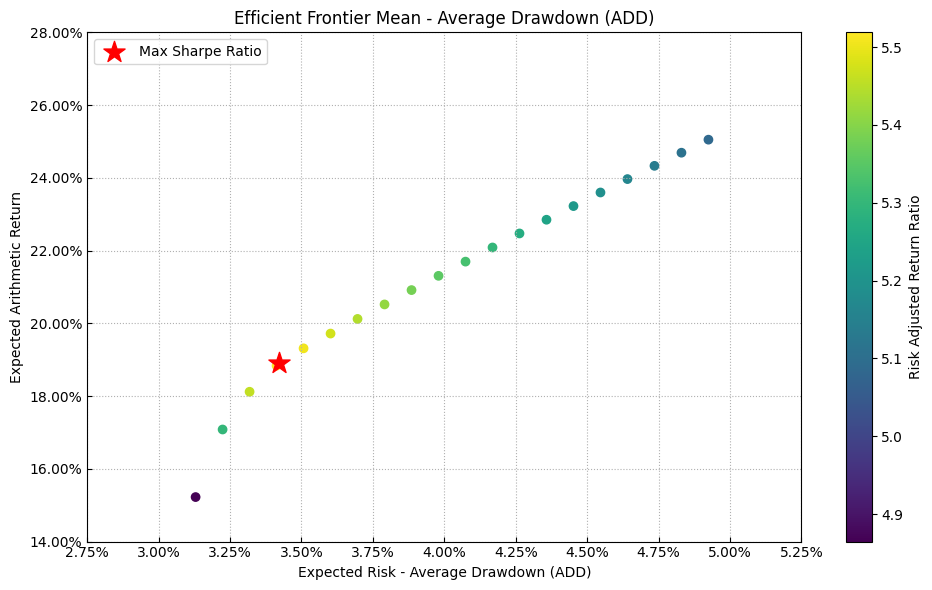

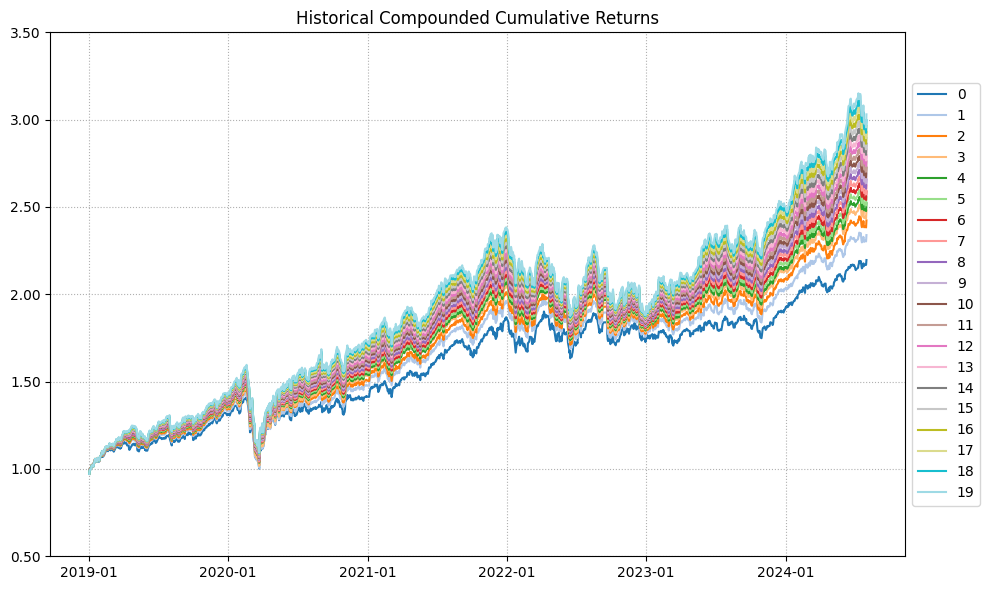

In [10]:
#Average Drawdown
points = 20 # Number of points of the frontier

frontierADD = port2.efficient_frontier(model=model, rm="ADD", points=points, rf=rf, hist=True)

display(frontierADD)

# Grafico
label = 'Max Sharpe Ratio' # Title of point

axADD = rp.plot_frontier(w_frontier=frontierADD, mu=port2.mu, cov=port2.cov, returns=Y, rm="ADD",
                      rf=rf, alpha=0.05, cmap='viridis', w=w_s3[["ADD"]], label=label,
                      marker='*', s=16, c='r', height=6, width=10, ax=None)

plt.show()

axRet = rp.plot_series(returns=Y, w=frontierADD, cmap="tab20", height=6, width=10, ax=None)
plt.show()


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
XDWH.MI,0.54613,0.658507,0.605421,0.560362,0.520224,0.482712,0.449256,0.418439,0.388406,0.359471,0.331444,0.304222,0.277873,0.251948,0.226219,0.200491,0.174767,0.149325,0.124611,0.1
XDWT.MI,0.10000,0.141493,0.194579,0.239638,0.279776,0.317288,0.350744,0.381561,0.411594,0.440529,0.468556,0.495778,0.522127,0.548052,0.573781,0.599509,0.625233,0.650675,0.675389,0.7
INFR.MI,0.25387,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.1
XDWM.MI,0.10000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.1


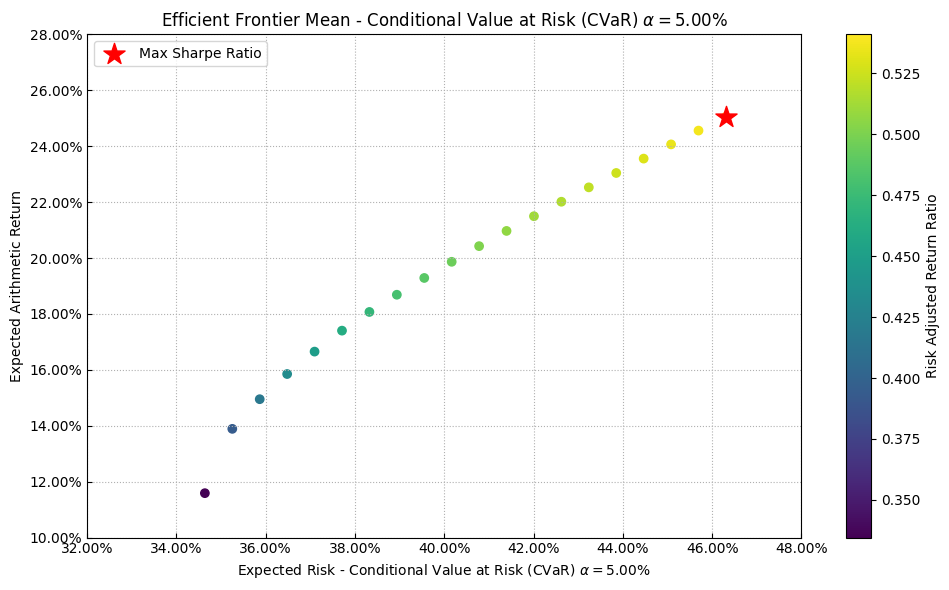

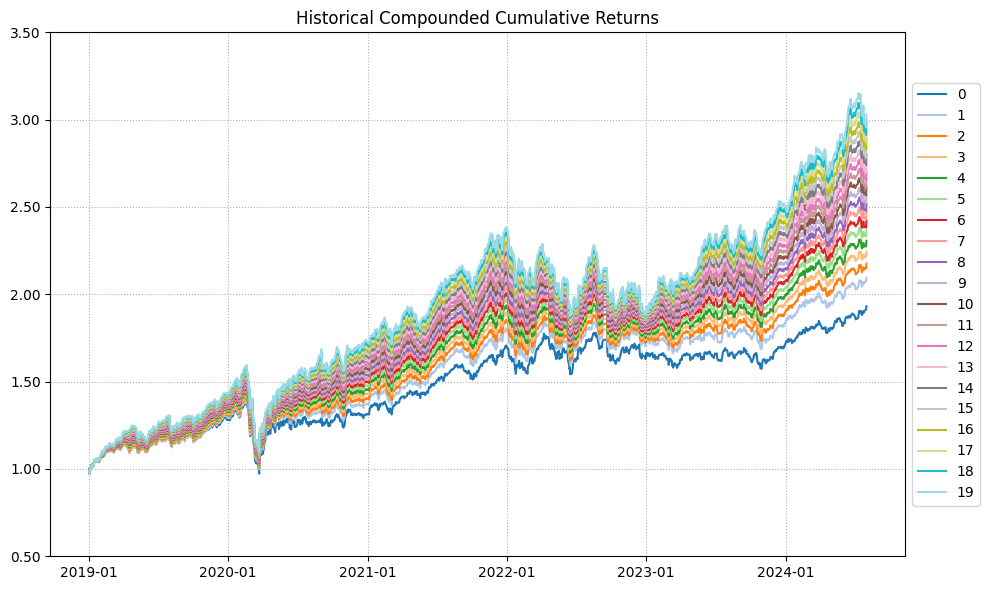

In [11]:
#Conditional Valuea at Risk
points = 20 # Number of points of the frontier

frontierCVaR = port2.efficient_frontier(model=model, rm="CVaR", points=points, rf=rf, hist=True)

display(frontierCVaR)

# Grafico
label = 'Max Sharpe Ratio' # Title of point

axCVaR = rp.plot_frontier(w_frontier=frontierCVaR, mu=port2.mu, cov=port2.cov, returns=Y, rm="CVaR",
                      rf=rf, alpha=0.05, cmap='viridis', w=w_s3[["CVaR"]], label=label,
                      marker='*', s=16, c='r', height=6, width=10, ax=None)
plt.show()

axRet = rp.plot_series(returns=Y, w=frontierCVaR, cmap="tab20", height=6, width=10, ax=None)
plt.show()


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
XDWH.MI,0.7,0.623647,0.56365,0.509408,0.460161,0.425888,0.393624,0.365513,0.340458,0.316143,0.292943,0.270612,0.248442,0.226649,0.205074,0.183584,0.162353,0.141194,0.120475,0.1
XDWT.MI,0.1,0.176353,0.23635,0.290592,0.339839,0.374112,0.406376,0.434487,0.459542,0.483857,0.507057,0.529388,0.551558,0.573351,0.594926,0.616416,0.637647,0.658806,0.679525,0.7
INFR.MI,0.1,0.100000,0.10000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.1
XDWM.MI,0.1,0.100000,0.10000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.1


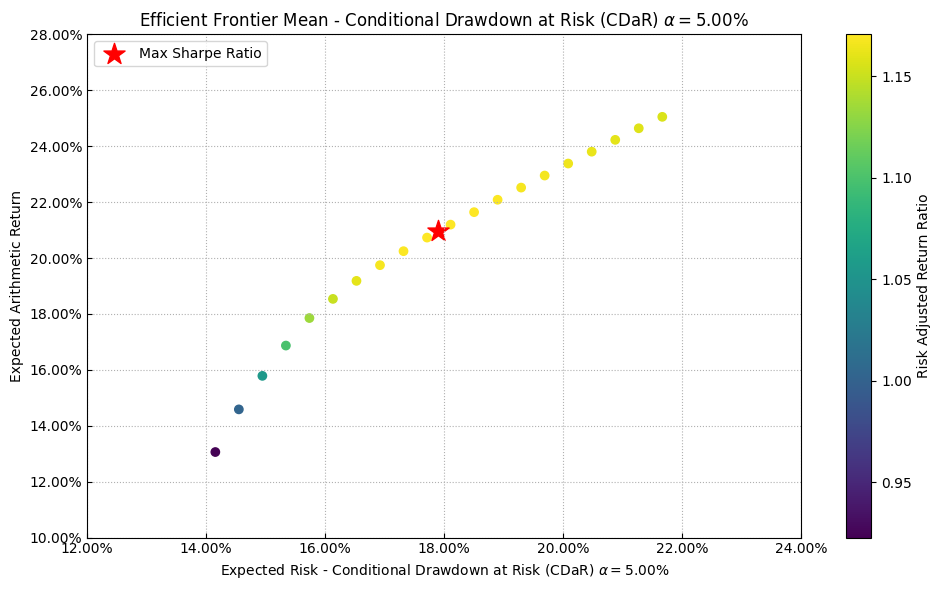

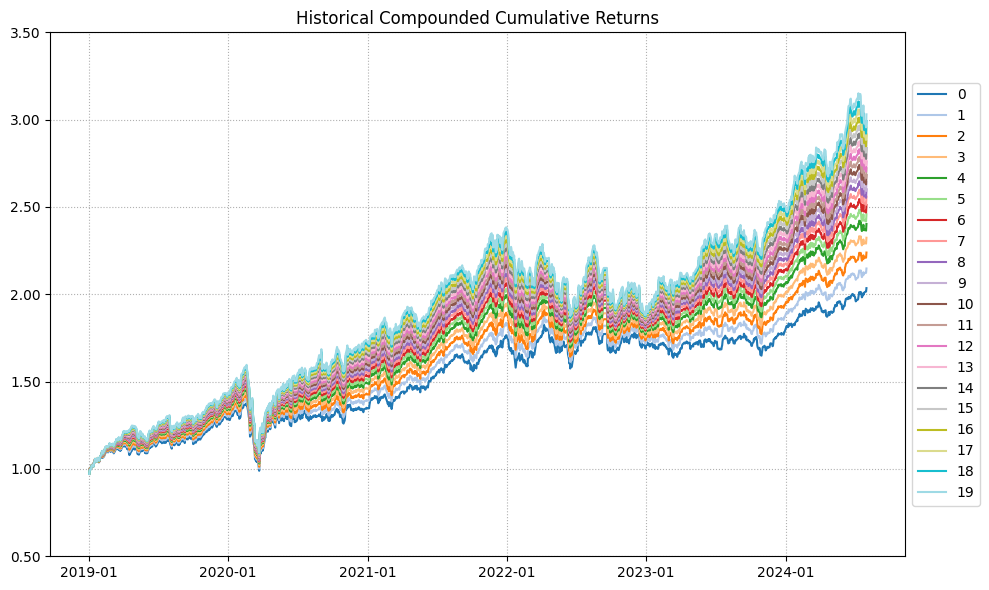

In [12]:
#Conditional Drawdown at Risk
points = 20 # Number of points of the frontier

frontierCDaR = port2.efficient_frontier(model=model, rm="CDaR", points=points, rf=rf, hist=True)

display(frontierCDaR)

# Grafico
label = 'Max Sharpe Ratio' # Title of point

axCDaR = rp.plot_frontier(w_frontier=frontierCDaR, mu=port2.mu, cov=port2.cov, returns=Y, rm="CDaR",
                      rf=rf, alpha=0.05, cmap='viridis', w=w_s3[["CDaR"]], label=label,
                      marker='*', s=16, c='r', height=6, width=10, ax=None)
plt.show()

axRet = rp.plot_series(returns=Y, w=frontierCDaR, cmap="tab20", height=6, width=10, ax=None)
plt.show()


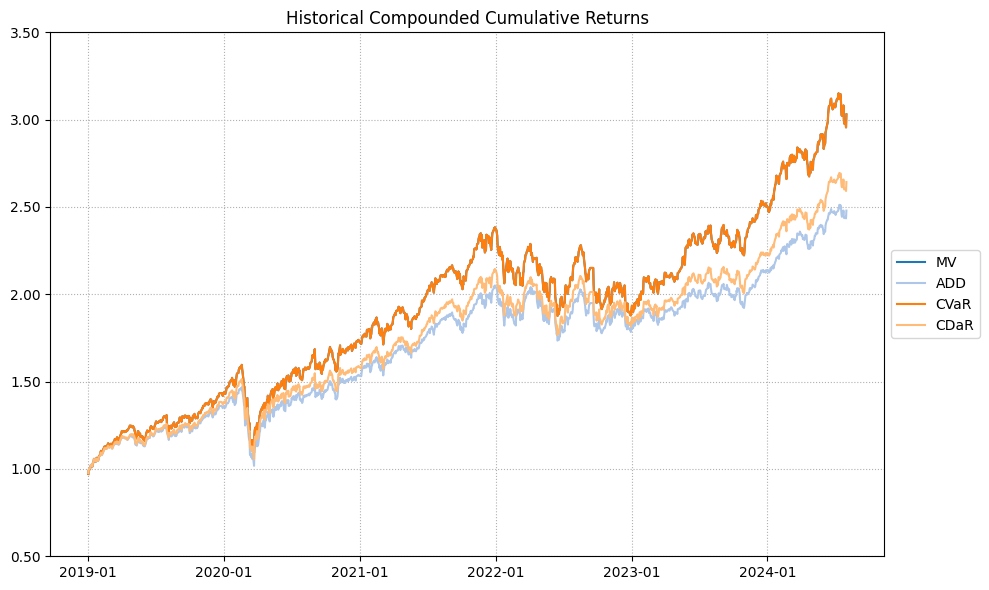

Risk Contribution for each asset with MV method


,0,0
0,XDWH.MI,0.000695
1,XDWT.MI,0.009679
2,INFR.MI,0.000644
3,XDWM.MI,0.000819



Risk Contribution for each asset with ADD method


,0,0
0,XDWH.MI,0.006225
1,XDWT.MI,0.018787
2,INFR.MI,0.003915
3,XDWM.MI,0.005210



Risk Contribution for each asset with CVaR method


,0,0
0,XDWH.MI,0.001771
1,XDWT.MI,0.023406
2,INFR.MI,0.001808
3,XDWM.MI,0.002187



Risk Contribution for each asset with CDaR method


,0,0
0,XDWH.MI,0.028220
1,XDWT.MI,0.123473
2,INFR.MI,0.011054
3,XDWM.MI,0.014353


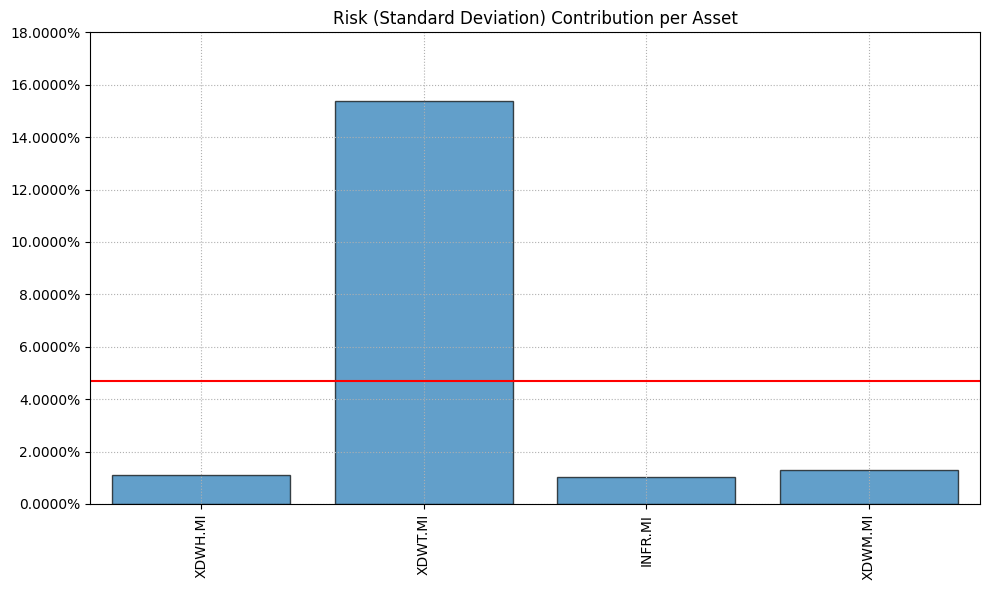

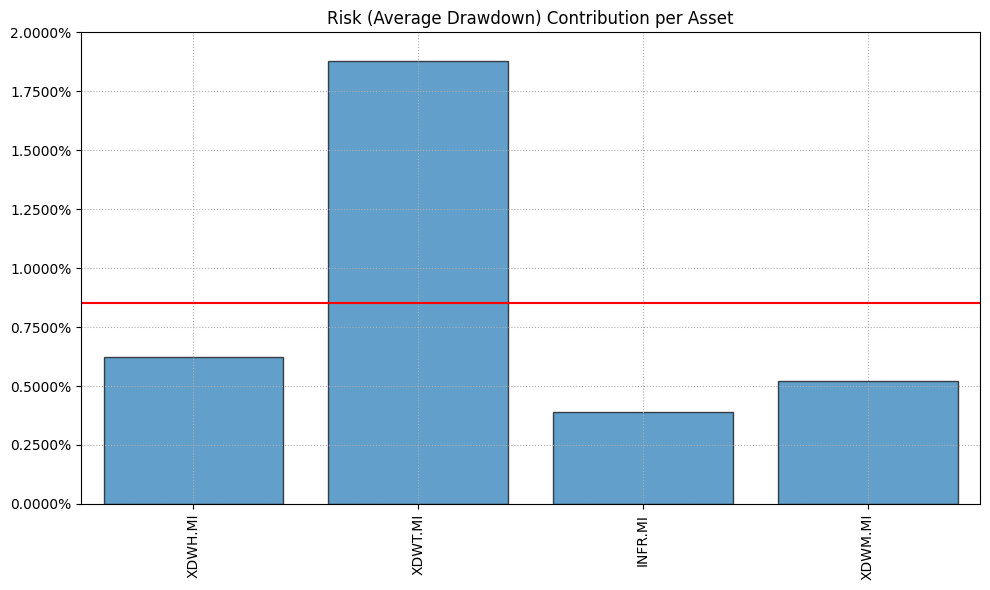

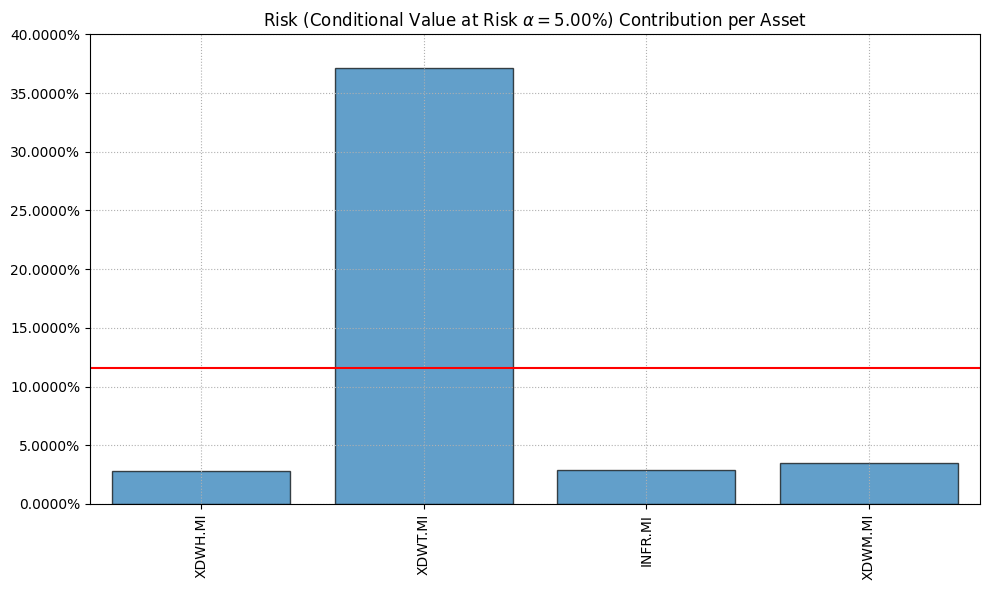

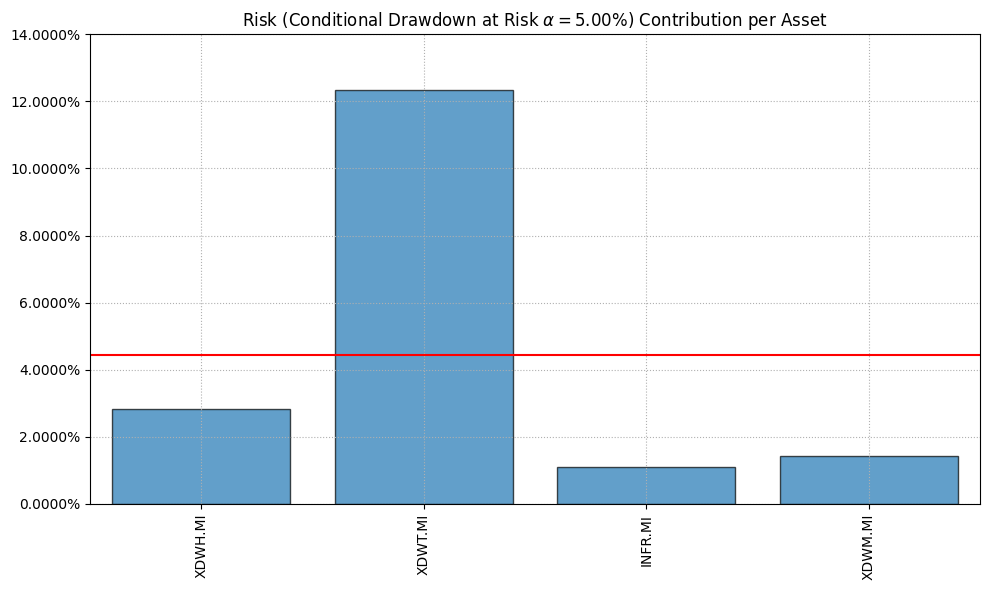

In [46]:
#Confronto Cum Ret dei portafoglio ipoteticamente migliori
w_opt = pd.concat([frontierMV[19],frontierADD[3],frontierCVaR[19],frontierCDaR[9]],axis=1)
w_opt.columns = rms2
axRet = rp.plot_series(returns=Y, w=w_opt, cmap="tab20", height=6, width=10, ax=None)
plt.show()

# risk contribution for each asset in each risk measure considered for the optimal portfolio
rc_MV = rp.Risk_Contribution(w=frontierMV[19], cov=port2.cov, returns=Y, rm="MV", rf=rf)
print("Risk Contribution for each asset with MV method")
display(pd.concat([sample,pd.DataFrame(rc_MV)],axis=1))

rc_ADD = rp.Risk_Contribution(w=frontierADD[3], cov=port2.cov, returns=Y, rm="ADD", rf=rf)
print("\nRisk Contribution for each asset with ADD method")
display(pd.concat([sample,pd.DataFrame(rc_ADD)],axis=1))

rc_CVaR = rp.Risk_Contribution(w=frontierCVaR[19], cov=port2.cov, returns=Y, rm="CVaR", rf=rf)
print("\nRisk Contribution for each asset with CVaR method")
display(pd.concat([sample,pd.DataFrame(rc_CVaR)],axis=1))

rc_CDaR = rp.Risk_Contribution(w=frontierCDaR[9], cov=port2.cov, returns=Y, rm="CDaR", rf=rf)
print("\nRisk Contribution for each asset with CDaR method")
display(pd.concat([sample,pd.DataFrame(rc_CDaR)],axis=1))


# Bar Plot of risk contribution
axMV = rp.PlotFunctions.plot_risk_con(w=pd.DataFrame(frontierMV[19]), cov=port2.cov, returns=Y, rm='MV',
                                             rf=rf, alpha=0.05, height=6, width=10, ax=None)
plt.show()

axADD = rp.PlotFunctions.plot_risk_con(w=pd.DataFrame(frontierADD[3]), cov=port2.cov, returns=Y, rm='ADD',
                                             rf=rf, alpha=0.05, height=6, width=10, ax=None)
plt.show()

axCVaR = rp.PlotFunctions.plot_risk_con(w=pd.DataFrame(frontierCVaR[19]), cov=port2.cov, returns=Y, rm='CVaR',
                                             rf=rf, alpha=0.05, height=6, width=10, ax=None)
plt.show()

axCDaR = rp.PlotFunctions.plot_risk_con(w=pd.DataFrame(frontierCDaR[9]), cov=port2.cov, returns=Y, rm='CDaR',
                                             rf=rf, alpha=0.05, height=6, width=10, ax=None)
plt.show()

In [28]:
#Create Reports

rp.excel_report(Y,
                frontierMV,
                rf=0,
                alpha=0.05,
                t_factor=252,
                ini_days=1,
                days_per_year=252,
                name="Mean-MV Min Risk")

rp.excel_report(Y,
                frontierADD,
                rf=0,
                alpha=0.05,
                t_factor=252,
                ini_days=1,
                days_per_year=252,
                name="Mean-ADD Min Risk")

rp.excel_report(Y,
                frontierCVaR,
                rf=0,
                alpha=0.05,
                t_factor=252,
                ini_days=1,
                days_per_year=252,
                name="Mean-CVaR Min Risk")

rp.excel_report(Y,
                frontierCDaR,
                rf=0,
                alpha=0.05,
                t_factor=252,
                ini_days=1,
                days_per_year=252,
                name="Mean-CDaR Min Risk")